<a href="https://colab.research.google.com/github/GGlivePh/BSF_Phenotyping_pipelines/blob/main/SexPrediction_ReadImageExcel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/GGlivePh/BSF_Phenotyping_pipelines.git

Cloning into 'BSF_Phenotyping_pipelines'...
remote: Enumerating objects: 2797, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2797 (delta 7), reused 0 (delta 0), pack-reused 2777 (from 1)
Receiving objects: 100% (2797/2797), 261.72 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (2215/2215), done.
Filtering content: 100% (2202/2202), 716.96 MiB | 17.14 MiB/s, done.


In [2]:
import os
os.chdir('BSF_Phenotyping_pipelines')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import pandas as pd
import os
import cv2
import numpy as np
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
# the images vary in size, therefore this function resizes all of them to 224
def resize_and_pad_white(image, target_size=(224, 224)):
    # Convert the NumPy array image to a PIL Image
    pil_image = Image.fromarray(image)

    # Calculate the aspect ratio of the original image
    width, height = pil_image.size
    aspect_ratio = width / height

    # Calculate the target aspect ratio
    target_width, target_height = target_size
    target_aspect_ratio = target_width / target_height

    if aspect_ratio > target_aspect_ratio:
        # Original image is wider, fix the width to match the target width
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        # Original image is taller, fix the height to match the target height
        new_width = int(target_height * aspect_ratio)
        new_height = target_height

    # Resize the image to the calculated size
    resized_image = pil_image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new blank image with the target size and white background
    padded_image = Image.new('RGB', target_size, (255, 255, 255))

    # Calculate the position to center the resized image
    left = (target_width - new_width) // 2
    top = (target_height - new_height) // 2

    # Paste the resized image onto the blank image
    padded_image.paste(resized_image, (left, top))
    return np.array(padded_image)

In [5]:
# DATASET
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, excel_file, transform=None):

        self.images = []
        self.labels = []  # Initialize an empty list for labels
        self.img_dir = img_dir
        self.transform = transform

        # Read data from Excel file
        excel_data = pd.read_excel(excel_file)
        excel_data = excel_data.dropna(subset=['Sex'])

        for index, row in excel_data.iterrows():
            sex = row['Sex']

            # Handling NaN values for sex
            if pd.notnull(sex):
                img_filename = f"{str(row['L_ID']).zfill(4)}.jpg"  # Generating filename based on L_ID
                img_path = os.path.join(self.img_dir, img_filename)

                if os.path.exists(img_path):
                    image = cv2.imread(img_path)
                    image = resize_and_pad_white(image, target_size=(224, 224))
                    image = np.asarray(image)

                    if self.transform:
                      image = Image.fromarray(image)

                      image = self.transform(image)

                    #weight = float(row['Weight_Normal'])
                    #length = float(row['Length_Normal'])


            # Convert sex to a numerical label (e.g., 'F' -> 1, 'M' -> 0)
            sex = 1.0 if sex == 'F' else 0.0


            self.images.append({
                'image': image,
                #'weight': weight,
                #'length': length,
                'sex': sex
            })

            self.labels.append(sex)  # Append the label to the 'labels' list

        # Convert the 'labels' list to a NumPy array (optional)
        self.labels = np.array(self.labels)

        #self.num_classes = 2  # Assuming binary classification (change if different)
        # Balance the classes
        class_samples = {}
        for idx, label in enumerate(self.labels):
            if label not in class_samples:
                class_samples[label] = []
            class_samples[label].append(idx)

        # Determine the minimum number of samples among classes
        min_samples = min(len(samples) for samples in class_samples.values())

        # Select equal number of samples from each class
        selected_samples = []
        for label, samples in class_samples.items():
            selected_samples.extend(samples[:min_samples])

        # Update images and labels with balanced data
        self.images = [self.images[idx] for idx in selected_samples]
        self.labels = [self.labels[idx] for idx in selected_samples]

        # Count the number of classes in the balanced dataset
        unique_classes, class_counts = np.unique(self.labels, return_counts=True)
        self.num_classes = len(unique_classes)
        self.class_counts = dict(zip(unique_classes, class_counts))



    def get_num_classes(self):
        return self.num_classes

    def get_class_counts(self):
        return self.class_counts

    def __getitem__(self, idx):
        image = self.images[idx]['image']
        sex_label = torch.tensor(self.images[idx]['sex'], dtype=torch.float32).unsqueeze(0)

        return image, sex_label


    def __len__(self):

        return len(self.images)

In [6]:
# Create the dataloaders
#this takes about 3 minutes to load
img_path = "Larva-Balanced"
excel_file = "Dataset1_Normalized_New.xlsx"
#common_transform = transforms.Compose([transforms.ToTensor()])  # Add more transformations if needed
# preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = CustomImageDataset(img_path, excel_file, transform=preprocess)
from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    stratify=dataset.labels,  # Ensure stratified splitting based on 'Sex'
    random_state=42
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [7]:
import torchvision
import torch.nn as nn

# Load pretrained EfficientNet
model = torchvision.models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)

# Get the input features to the final classifier
num_features = model.classifier[1].in_features

# Unfreeze all layers (fine-tuning)
for param in model.parameters():
    param.requires_grad = True

# Replace the classifier for binary classification
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 53.5MB/s]


In [8]:

# Define loss function, optimizer, and dataloaders
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
num_epochs = 18
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)
vali_loss = []
train_loss = []
for epoch in range(num_epochs):
    running_loss = 0
    model.train()
    item = 0

    for batch in train_loader:
        # Assuming each batch contains both image and auxiliary inputs
        images, labels = batch
        #images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze()  ## NEWLLLLLLLLLLL REMOVE
        #outputs = outputs.squeeze()
        #loss = criterion(outputs.squeeze(), labels.long())
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    total_loss = running_loss/len(train_loader)
    train_loss.append(total_loss)
# Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    torch.no_grad()
    for i,batch in enumerate(val_loader) :
        #images, weight, length, labels = batch
        batch_size = len(batch)
        images, labels = batch

        outputs = model(images,)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.squeeze())
        val_loss += loss.item()
        predicted = (outputs > 0.5).squeeze().float()
        #_, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()
        true_labels.extend(labels.tolist())
        predicted_labels.extend([predicted])

    #validation_loss = val_loss / batch_size
    validation_loss = val_loss / len(val_loader)
    vali_loss.append(validation_loss)

    print("Correct =", correct, ", Total =",total)
    accuracy = (correct / total)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train_Loss: {total_loss} , Valid_Loss: {validation_loss}')
print("Accuracy :", accuracy)



Correct = 93 , Total = 136
Epoch 1/18, Train_Loss: 0.6862815215307123 , Valid_Loss: 0.6723436713218689
Correct = 96 , Total = 136
Epoch 2/18, Train_Loss: 0.6619445979595184 , Valid_Loss: 0.6493966579437256
Correct = 102 , Total = 136
Epoch 3/18, Train_Loss: 0.6264114853213815 , Valid_Loss: 0.6134644283188714
Correct = 103 , Total = 136
Epoch 4/18, Train_Loss: 0.5761634435723809 , Valid_Loss: 0.5618941916359795
Correct = 110 , Total = 136
Epoch 5/18, Train_Loss: 0.5300214089014951 , Valid_Loss: 0.5136241217454275
Correct = 111 , Total = 136
Epoch 6/18, Train_Loss: 0.47448787356124206 , Valid_Loss: 0.4932999677128262
Correct = 112 , Total = 136
Epoch 7/18, Train_Loss: 0.4026077727184576 , Valid_Loss: 0.4898748563395606
Correct = 113 , Total = 136
Epoch 8/18, Train_Loss: 0.35436008213197484 , Valid_Loss: 0.4590737654103173
Correct = 115 , Total = 136
Epoch 9/18, Train_Loss: 0.33564463739886 , Valid_Loss: 0.4571682877010769
Correct = 112 , Total = 136
Epoch 10/18, Train_Loss: 0.32852784062

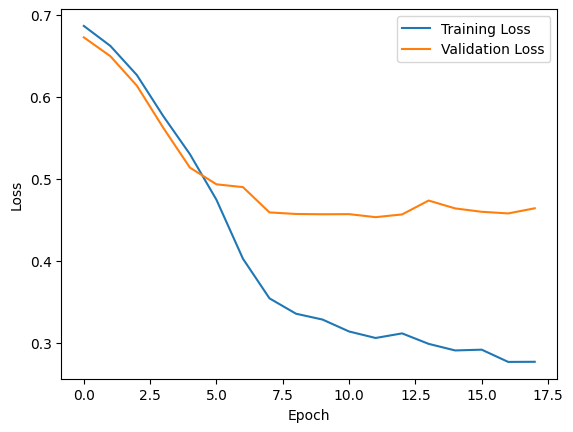

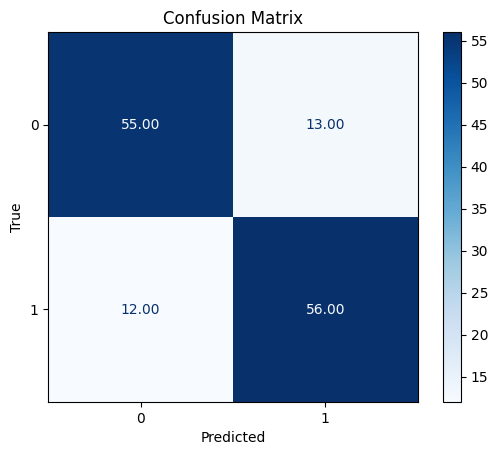

Precision: 0.8115942028985508
Recall (Sensitivity): 0.8235294117647058
F1 Score: 0.8175182481751825


In [9]:
# Plotting the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(vali_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Save the trained model if needed
torch.save(model.state_dict(), 'EFFICIENTNET_model.pth')

true_labels2 = [labels[0] for labels in true_labels]
predicted_labels2 = [num.item() for tensor in predicted_labels for num in tensor]
cm = confusion_matrix(true_labels2, predicted_labels2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Extract TP, FP, and FN from the confusion matrix
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculate Precision, Recall, and F1 Score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Avoid division by zero
recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero

f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1 Score:", f1_score)



In [10]:
#PERFORMING INFERENCE WITH THE TRAINED MODEL.

import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b2


# Load trained model
# Recreate the model architecture
model = models.efficientnet_b2(weights=None)  # or use same variant you trained with
model.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

# Now load weights
state_dict = torch.load("EFFICIENTNET_model.pth", map_location="cpu")
#model.load_state_dict(state_dict)

image = Image.open("Larva-Balanced/1402.jpg").convert('RGB')
np_image = np.array(image)
resized_padded_image = resize_and_pad_white(np_image, target_size=(224, 224))
pil_resized = Image.fromarray(resized_padded_image)

# preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(pil_resized).unsqueeze(0)  # add batch dim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_tensor = input_tensor.to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prediction = torch.round(output).item()  # 0 or 1
print(f"Predicted class: {int(prediction)}")



Predicted class: 0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 781.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s 

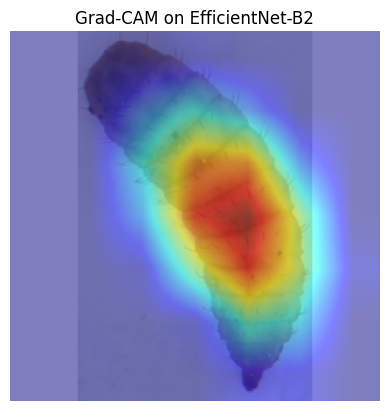

In [12]:
!pip install grad-cam

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Load model architecture and adjust classifier for EfficientNet-B2
model = models.efficientnet_b2(weights=None)
model.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

# Load trained weights
state_dict = torch.load("models/EFFICIENTNET_model.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

# Load and preprocess image
image_path = "Larva-Balanced/0001.jpg"
pil_image = Image.open(image_path).convert('RGB')

def resize_and_pad_white(image, target_size=(224, 224)):
    pil_image = Image.fromarray(image)
    width, height = pil_image.size
    aspect_ratio = width / height
    target_width, target_height = target_size
    target_aspect_ratio = target_width / target_height

    if aspect_ratio > target_aspect_ratio:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_width = int(target_height * aspect_ratio)
        new_height = target_height

    resized_image = pil_image.resize((new_width, new_height), Image.LANCZOS)
    padded_image = Image.new('RGB', target_size, (255, 255, 255))
    left = (target_width - new_width) // 2
    top = (target_height - new_height) // 2
    padded_image.paste(resized_image, (left, top))
    return np.array(padded_image)

np_image = np.array(pil_image)
resized_padded_image = resize_and_pad_white(np_image, (224, 224))
pil_resized = Image.fromarray(resized_padded_image)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(pil_resized).unsqueeze(0)

# Move model and tensor to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_tensor = input_tensor.to(device)

# Automatically find the last Conv2d layer for GradCAM
conv_layers = [m for m in model.features.modules() if isinstance(m, nn.Conv2d)]
target_layer = conv_layers[-1]

print("Using GradCAM target layer:", target_layer)

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Generate GradCAM heatmap
grayscale_cam = cam(input_tensor=input_tensor)[0, :]

# Prepare image for overlay (unnormalize)
input_np = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
input_np = input_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
input_np = np.clip(input_np, 0, 1)

# Create heatmap overlay
cam_image = show_cam_on_image(input_np, grayscale_cam, use_rgb=True)

# Display result
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM on EfficientNet-B2")
plt.show()
